In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysd
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy as sp

# Load Calibration data

In [183]:
data = pd.read_csv("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/data/dynamic/calibration_incidence.csv", sep=',',decimal='.')
data=data.drop("Unnamed: 0",axis=1)
data.head(23)
list(data.index*12)

[0,
 12,
 24,
 36,
 48,
 60,
 72,
 84,
 96,
 108,
 120,
 132,
 144,
 156,
 168,
 180,
 192,
 204,
 216,
 228,
 240,
 252,
 264]

Text(0.5, 1.0, 'Estimated Incident cases of TB')

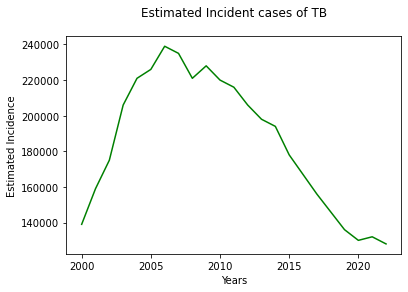

In [5]:
plt.plot(data["year"], data['Mean'],label="mean_estimate",color="green")
#plt=dataSoil.plot(x="days",y="bacteria_measured")
plt.xlabel('Years')
plt.ylabel('Estimated Incidence')
plt.title("Estimated Incident cases of TB",pad=20)

# Load Model

In [301]:
model = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V5_months.mdl")

In [302]:
model_output = model.run()
display(model_output.head(276))

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Detection,progression,CDR,CFR,deaths TB,Relapse,...,general mortality,infection,initial incident,initial latent,Latent TB infection,diagnostic delay,Detected and Treated TB,relapse rate,force of infection,progression rate
0,276,0,12,1,15333.333333,100000.000000,0.038333,0.007417,2966.666667,36.666667,...,0.000667,57705.951912,400000,1000000.0,1.000000e+06,1.5,5.500000e+04,0.000667,0.15,0.1
12,276,0,12,1,41659.230670,114714.926146,0.038333,0.007417,8742.933605,246.936014,...,0.000667,164544.961461,400000,1000000.0,1.147149e+06,1.5,3.704040e+05,0.000667,0.15,0.1
24,276,0,12,1,75970.729721,193062.443250,0.038333,0.007417,15755.008126,689.127282,...,0.000667,277646.056423,400000,1000000.0,1.930624e+06,1.5,1.033691e+06,0.000667,0.15,0.1
36,276,0,12,1,129895.762363,309140.906880,0.038333,0.007417,26745.367845,1463.224810,...,0.000667,421217.479287,400000,1000000.0,3.091409e+06,1.5,2.194837e+06,0.000667,0.15,0.1
48,276,0,12,1,206931.953933,444090.483679,0.038333,0.007417,42153.416515,2738.639054,...,0.000667,554205.622168,400000,1000000.0,4.440905e+06,1.5,4.107959e+06,0.000667,0.15,0.1
60,276,0,12,1,297539.130215,547388.846698,0.038333,0.007417,59721.524113,4667.285907,...,0.000667,602639.942543,400000,1000000.0,5.473888e+06,1.5,7.000929e+06,0.000667,0.15,0.1
72,276,0,12,1,375114.671193,562103.176999,0.038333,0.007417,73982.253074,7258.864233,...,0.000667,531339.048963,400000,1000000.0,5.621032e+06,1.5,1.088830e+07,0.000667,0.15,0.1
84,276,0,12,1,409799.822121,483627.952820,0.038333,0.007417,79421.712243,10283.896528,...,0.000667,394210.269258,400000,1000000.0,4.836280e+06,1.5,1.542584e+07,0.000667,0.15,0.1
96,276,0,12,1,392747.355806,364416.627506,0.038333,0.007417,75014.018718,13343.626941,...,0.000667,267654.192367,400000,1000000.0,3.644166e+06,1.5,2.001544e+07,0.000667,0.15,0.1
108,276,0,12,1,340275.026184,256324.168443,0.038333,0.007417,64328.141031,16074.329932,...,0.000667,181144.949250,400000,1000000.0,2.563242e+06,1.5,2.411149e+07,0.000667,0.15,0.1


<AxesSubplot:>

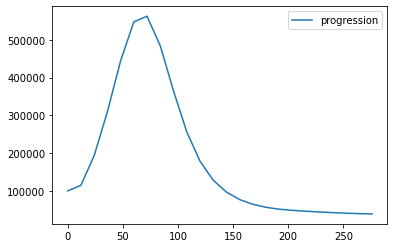

In [303]:
model_output.plot(y="progression")

## Calibration

In [304]:
#Set up observable and claibration parameters
observable = "progression"
parameter1 = 'force of infection'
parameter2 = 'relapse rate'
parameter3 = 'initial latent'
parameter4="progression rate"
parameter5 = 'CFR'



def error(param_list):
    #unpack the parameter list
    parameter1_value,parameter2_value,parameter3_value,parameter4_value,parameter5_value = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'force of infection':parameter1_value,
                               'relapse rate':parameter2_value,
                               'initial latent': parameter3_value,
                               "progression rate":parameter4_value,
                               'CFR': parameter5_value
                              },
                       return_columns=['progression'],
                       return_timestamps=list(data.index*12)[0:23])
    #print(result['progression'] -data['Mean'])
    
    result=result.reset_index(drop=True)
    #print(result)
    calDat=data.reset_index(drop=True)
    calDat=calDat["Mean"]
    
    error=sum((result['progression'] - calDat)**2)
    #print(error)
    #return the sum of the squared errors
    return  error

In [314]:
parameter1_guess = 0.05
parameter1_bounds = (0.0, 1)

parameter2_guess = 0.1
parameter2_bounds = (0.004, 1)

parameter3_guess = 100000
parameter3_bounds = (1, 3000000)

parameter4_guess = 0.08
parameter4_bounds = (0, 0.2)

parameter5_guess =0.4
parameter5_bounds = (0.1,1)

res = sp.optimize.minimize(error,
                           x0=[parameter1_guess,parameter2_guess,parameter3_guess,parameter4_guess,parameter5_guess],
                           method='L-BFGS-B',
                           bounds=[parameter1_bounds,parameter2_bounds,parameter3_bounds,parameter4_bounds,parameter5_bounds])
res

      fun: 14306736411.984627
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.62460133e+08, -4.34818266e+07, -4.00074419e+03, -3.14108723e+10,
        6.79347416e+08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1362
      nit: 127
     njev: 227
   status: 0
  success: True
        x: array([5.49274421e-01, 1.00000000e+00, 5.88122138e+05, 2.00000000e-01,
       5.12840418e-01])

In [315]:
p1, p2, p3,p4,p5= res.x
result = model.run(params=
                   {
                       'force of infection':p1,
                               'relapse rate':p2,
                               'initial latent': p3,
                               "progression rate":p4,
                               "CFR":p5
                   },
                   return_columns=['progression'])

result=result.reset_index(drop=True)
result["year"]=data["year"]

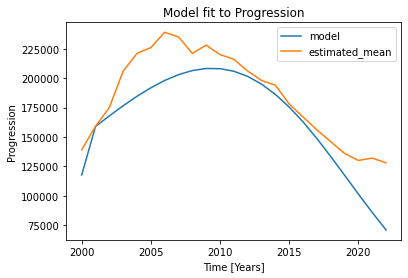

In [316]:
plt.plot(result["year"], result['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='estimated_mean');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')
plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)